## Environment and Reproducibility
This section imports libraries and sets deterministic seeds for preprocessing and pseudo-label generation. Keeping this at the top makes later outputs easier to reproduce.


In [30]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, GINConv, SAGEConv
from torch_geometric.utils import to_undirected, remove_self_loops

import networkx as nx
from community import community_louvain

# Reproducibility for preprocessing and pseudo-label generation
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


## Load Node Features
This section reads the sparse feature JSON and computes the node count and feature dimensionality. These values define the shape of all downstream tensors.


In [31]:
import json

file_path = "git_web_ml/musae_git_features.json"
with open(file_path, "r") as f:
    features_dict = json.load(f)

N = len(features_dict)
max_index = 0
for feature_list in features_dict.values():
    if len(feature_list) > 0:
        max_index = max(max_index, max(feature_list))


D = max_index + 1
print("Number of nodes N is ->", N)
print("Feature dimension D is ->", D)


Number of nodes N is -> 37700
Feature dimension D is -> 4005


In [32]:
import torch

row_indices = []
col_indices = []

for node_id, feature_list in features_dict.items():
    node = int(node_id)
    for feature_idx in feature_list:
        row_indices.append(node)
        col_indices.append(feature_idx)

values = torch.ones(len(row_indices), dtype=torch.float)
indices = torch.tensor([row_indices, col_indices], dtype=torch.long)
x = torch.sparse_coo_tensor(
    indices,
    values,
    size=(N, D)
)

print("Sparse feature matrix shape:", tuple(x.shape))
print("Number of non-zero entries:", x._nnz())


Sparse feature matrix shape: (37700, 4005)
Number of non-zero entries: 690374


## Build Edge Index
This section loads the follower graph and converts it into a PyG-compatible undirected `edge_index`. Self-loops are removed before message passing.


In [33]:
edge_path = "git_web_ml/musae_git_edges.csv"
edges = pd.read_csv(edge_path)

edge_index = torch.tensor(edges.values.T, dtype=torch.long)
edge_index, _ = remove_self_loops(edge_index)
edge_index = to_undirected(edge_index, num_nodes=N)

print("Edge index shape:", tuple(edge_index.shape))
print("Number of directed edge entries in edge_index:", edge_index.shape[1])
print("Number of undirected edges (approx):", edge_index.shape[1] // 2)


Edge index shape: (2, 578006)
Number of directed edge entries in edge_index: 578006
Number of undirected edges (approx): 289003


## Basic Degree Statistics
This section computes quick structural diagnostics from the graph. It is a sanity check before community detection.


In [ ]:
import torch

row = edge_index[0]
degree = torch.bincount(row, minlength=N)
print("Min degree:", degree.min().item())
print("Max degree:", degree.max().item())
print("Average degree:", degree.float().mean().item())

Min degree: 1
Max degree: 9458
Average degree: 15.331724166870117


## Degree Distribution Plots
These plots help inspect whether the graph is heavy-tailed and skewed. They are useful for understanding graph sparsity and hub behavior.


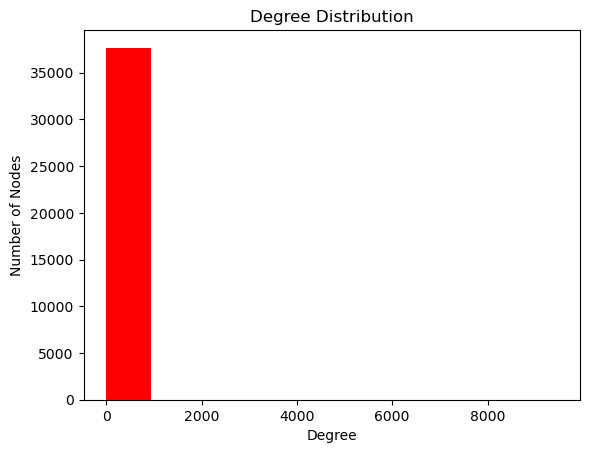

In [35]:
import matplotlib.pyplot as plt

deg_np = degree.numpy()
plt.figure()
plt.hist(deg_np, bins=10, color='red')
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution")
plt.show()


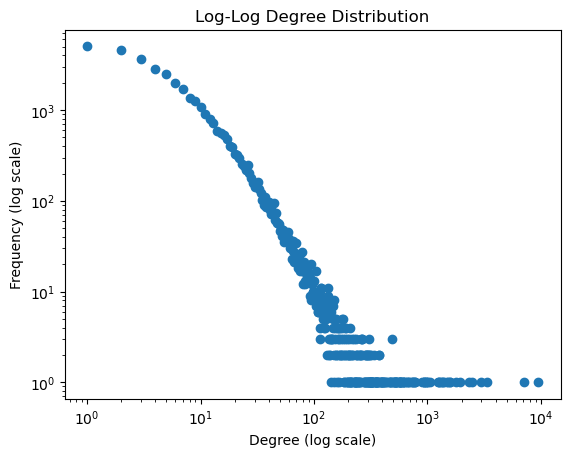

In [36]:
import numpy as np

unique_deg, counts = np.unique(deg_np, return_counts=True)
plt.figure()
plt.loglog(unique_deg, counts, marker='o', linestyle='none')
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Log-Log Degree Distribution")
plt.show()


## Build NetworkX Graph and Global Graph Metrics
This section creates an undirected NetworkX graph for community detection. It also reports density and transitivity as global topology summaries.


In [37]:
edge_list = edge_index.t().tolist()
G = nx.Graph()
G.add_edges_from(edge_list)

print("Number of nodes in G:", G.number_of_nodes())
print("Number of edges in G:", G.number_of_edges())
print("Graph density:", nx.density(G))
print("Transitivity (global clustering coefficient):", nx.transitivity(G))


Number of nodes in G: 37700
Number of edges in G: 289003
Graph density: 0.0004066878203117068
Transitivity (global clustering coefficient): 0.012357188884259466


## Louvain Community Detection 
This section runs Louvain clustering and selects the highest-modularity partition across several seeds. The resulting communities are used only as self-supervised pseudo-label structure.


In [38]:
candidate_seeds = [0, 1, 2, 42, 99]
best_partition = None
best_modularity = -1.0

for s in candidate_seeds:
    # Run Louvain with multiple seeds and keep the highest modularity partition.
    part = community_louvain.best_partition(G, random_state=s)
    mod = community_louvain.modularity(part, G)
    num_comms = len(set(part.values()))
    print(f"seed={s} -> communities={num_comms}, modularity={mod:.6f}")
    if mod > best_modularity:
        best_modularity = mod
        best_partition = part

partition = best_partition

community_labels = torch.zeros(N, dtype=torch.long)
unique_comms = sorted(set(partition.values()))
comm_map = {old_id: new_id for new_id, old_id in enumerate(unique_comms)}

for node in range(N):
    community_labels[node] = comm_map[partition[node]]

print("Selected partition modularity:", best_modularity)
print("Number of communities:", community_labels.unique().numel())


seed=0 -> communities=41, modularity=0.451384
seed=1 -> communities=53, modularity=0.448372
seed=2 -> communities=38, modularity=0.449680
seed=42 -> communities=40, modularity=0.448008
seed=99 -> communities=28, modularity=0.452887
Selected partition modularity: 0.4528865154057818
Number of communities: 28


In [39]:
modularity = community_louvain.modularity(partition, G)
print("Modularity score:", modularity)


Modularity score: 0.4528865154057818


## Community Size Diagnostics
This section summarizes community size distribution and highlights imbalance. It helps decide whether tiny communities should be filtered during pair/triplet sampling.


In [40]:
from collections import Counter
import numpy as np

community_sizes = Counter(community_labels.tolist())
sizes = np.array(list(community_sizes.values()), dtype=int)

print("Number of communities:", len(sizes))
print("Min community size:", int(sizes.min()))
print("Max community size:", int(sizes.max()))
print("Mean community size:", float(sizes.mean()))
print("Median community size:", float(np.median(sizes)))
sorted_sizes = sorted([int(x) for x in sizes], reverse=True)
print("Top 5 largest communities:", sorted_sizes[:5])
print("Bottom 5 smallest communities:", sorted_sizes[-5:])


Number of communities: 28
Min community size: 3
Max community size: 7464
Mean community size: 1346.4285714285713
Median community size: 15.5
Top 5 largest communities: [7464, 7254, 7161, 5287, 2883]
Bottom 5 smallest communities: [3, 3, 3, 3, 3]


## Community-to-Node Index
This section builds a lookup from each community to its member nodes. It enables efficient positive/negative sampling for contrastive learning.


In [41]:
from collections import defaultdict

community_to_nodes = defaultdict(list)
for node in range(N):
    comm_id = int(community_labels[node].item())
    community_to_nodes[comm_id].append(node)

for comm_id in list(community_to_nodes.keys()):
    community_to_nodes[comm_id] = torch.tensor(community_to_nodes[comm_id], dtype=torch.long)

print("Number of communities:", len(community_to_nodes))
for k in list(community_to_nodes.keys())[:3]:
    print(f"Community {k} size:", community_to_nodes[k].shape[0])


Number of communities: 28
Community 0 size: 7161
Community 1 size: 7254
Community 3 size: 2883


## Frontend Data Artifacts (From Louvain)
This section exports community-level and node-level artifacts derived from Louvain clustering. These files are frontend-friendly and can replace toy data while the GNN recommender remains a placeholder.


In [ ]:
import os
import json
from collections import Counter
import numpy as np
import pandas as pd

os.makedirs("artifacts/frontend", exist_ok=True)

# Node-level table for user lookups.
node_df = pd.DataFrame({
    "id": np.arange(N, dtype=int),
    "community_id": community_labels.numpy().astype(int),
    "degree": degree.numpy().astype(int),
})
node_df.to_csv("artifacts/frontend/node_community.csv", index=False)

# Community-level summary table.
community_sizes = Counter(community_labels.tolist())

def internal_density(nodes):
    sub = G.subgraph(nodes)
    n = sub.number_of_nodes()
    m = sub.number_of_edges()
    return 0.0 if n < 2 else (2.0 * m) / (n * (n - 1))

community_summary_rows = []
community_top_features = {}
community_representatives = {}

for comm_id, nodes_tensor in community_to_nodes.items():
    nodes = nodes_tensor.tolist()
    sub_deg = [G.degree(n) for n in nodes]

    community_summary_rows.append({
        "community_id": int(comm_id),
        "size": int(len(nodes)),
        "internal_density": float(internal_density(nodes)),
        "avg_degree": float(np.mean(sub_deg)),
        "max_degree": int(np.max(sub_deg)),
    })

    # Top sparse-feature indices by frequency inside this community.
    feat_counter = Counter()
    for n in nodes:
        for f in features_dict[str(n)]:
            feat_counter[int(f)] += 1
    community_top_features[str(int(comm_id))] = [
        {"feature_idx": int(fid), "count": int(cnt)}
        for fid, cnt in feat_counter.most_common(15)
    ]

    # Representative nodes by structural prominence within the community.
    rep_nodes = sorted(nodes, key=lambda n: G.degree(n), reverse=True)[:10]
    community_representatives[str(int(comm_id))] = [int(n) for n in rep_nodes]

community_summary_df = pd.DataFrame(community_summary_rows).sort_values("size", ascending=False)
community_summary_df.to_csv("artifacts/frontend/community_summary.csv", index=False)

with open("artifacts/frontend/community_top_features.json", "w", encoding="utf-8") as f:
    json.dump(community_top_features, f, indent=2)

with open("artifacts/frontend/community_representatives.json", "w", encoding="utf-8") as f:
    json.dump(community_representatives, f, indent=2)

print("Saved:")
print("- artifacts/frontend/node_community.csv")
print("- artifacts/frontend/community_summary.csv")
print("- artifacts/frontend/community_top_features.json")
print("- artifacts/frontend/community_representatives.json")
print("Communities:", len(community_summary_df))

## Inter-Community Graph for Visualization
This section builds a weighted graph between communities based on cross-community follower edges. It enables chord/network/sankey-style frontend visualizations without requiring trained embeddings.


In [ ]:
from collections import Counter

# Use original undirected edge list from CSV (one row per undirected edge).
comm_of = community_labels.numpy().astype(int)

pair_counter = Counter()
for _, row in edges.iterrows():
    u = int(row["id_1"])
    v = int(row["id_2"])
    cu = int(comm_of[u])
    cv = int(comm_of[v])
    if cu == cv:
        continue
    a, b = (cu, cv) if cu < cv else (cv, cu)
    pair_counter[(a, b)] += 1

community_edges = pd.DataFrame([
    {"source_community": a, "target_community": b, "weight": w}
    for (a, b), w in pair_counter.items()
]).sort_values("weight", ascending=False)

community_edges.to_csv("artifacts/frontend/community_edges.csv", index=False)

community_graph_payload = {
    "nodes": [
        {
            "community_id": int(r.community_id),
            "size": int(r.size),
            "internal_density": float(r.internal_density),
        }
        for r in community_summary_df.itertuples(index=False)
    ],
    "edges": [
        {
            "source": int(r.source_community),
            "target": int(r.target_community),
            "weight": int(r.weight),
        }
        for r in community_edges.itertuples(index=False)
    ],
}

with open("artifacts/frontend/community_graph.json", "w", encoding="utf-8") as f:
    json.dump(community_graph_payload, f, indent=2)

print("Saved:")
print("- artifacts/frontend/community_edges.csv")
print("- artifacts/frontend/community_graph.json")
print("Cross-community edges:", len(community_edges))


## Visualization: Largest Communities
This chart shows the largest detected communities by size. It is useful for a quick ecosystem segmentation overview in the dashboard.


In [ ]:
import matplotlib.pyplot as plt

top_k = 15
top_df = community_summary_df.head(top_k).copy()

plt.figure(figsize=(11, 4))
plt.bar(top_df["community_id"].astype(str), top_df["size"])
plt.title(f"Top {top_k} Communities by Size")
plt.xlabel("Community ID")
plt.ylabel("Number of Developers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Visualization: Cohesiveness vs Community Size
This scatter plot contrasts community size with internal density. It helps identify large-but-loose communities versus small-but-cohesive groups.


In [ ]:
plot_df = community_summary_df.copy()

plt.figure(figsize=(7, 5))
plt.scatter(plot_df["size"], plot_df["internal_density"], alpha=0.7)
plt.xscale("log")
plt.xlabel("Community Size (log scale)")
plt.ylabel("Internal Density")
plt.title("Community Size vs Internal Density")
plt.tight_layout()
plt.show()


## Visualization: Inter-Community Connectivity Heatmap
This heatmap highlights where cross-community interactions concentrate among the largest communities. It can be translated directly into frontend matrix/chord views.


In [ ]:
top_heat_k = 12
top_ids = community_summary_df.head(top_heat_k)["community_id"].tolist()
id_to_idx = {cid: i for i, cid in enumerate(top_ids)}

mat = np.zeros((top_heat_k, top_heat_k), dtype=float)
for r in community_edges.itertuples(index=False):
    a = int(r.source_community)
    b = int(r.target_community)
    w = int(r.weight)
    if a in id_to_idx and b in id_to_idx:
        i = id_to_idx[a]
        j = id_to_idx[b]
        mat[i, j] = w
        mat[j, i] = w

plt.figure(figsize=(7, 6))
plt.imshow(mat, cmap="YlOrRd")
plt.title(f"Inter-Community Edge Weights (Top {top_heat_k} by Size)")
plt.xticks(range(top_heat_k), top_ids, rotation=45)
plt.yticks(range(top_heat_k), top_ids)
plt.colorbar(label="Cross-Community Edge Count")
plt.tight_layout()
plt.show()


## Visualization: Local Ego Network Explorer (Sample)
This view shows a local neighborhood around one developer and colors nodes by Louvain community. It provides an interpretable graph snapshot for profile-level frontend pages.


In [ ]:
import random

sample_user = random.choice(range(N))
first_hop = set(G.neighbors(sample_user))

# Limit neighbors for readability in notebook rendering.
max_neighbors = 60
if len(first_hop) > max_neighbors:
    first_hop = set(random.sample(list(first_hop), max_neighbors))

ego_nodes = {sample_user} | first_hop
ego_sub = G.subgraph(ego_nodes).copy()

node_colors = [community_labels[n].item() for n in ego_sub.nodes()]

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(ego_sub, seed=SEED)
nx.draw_networkx(
    ego_sub,
    pos=pos,
    node_size=60,
    with_labels=False,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    edge_color="#AAAAAA",
    width=0.6,
)
plt.title(f"Ego Network Around User {sample_user} (Colored by Community)")
plt.axis("off")
plt.tight_layout()
plt.show()


## Triplet Sampler for Self-Supervision
This sampler draws anchor-positive pairs from the same community and negatives from different communities. A minimum community size filter reduces noise in pseudo-supervision.


In [42]:
min_comm_size = 5

# Eligible communities for positive sampling
# Ignore tiny communities to reduce noisy positives.
eligible_comms = [c for c, nodes in community_to_nodes.items() if len(nodes) >= min_comm_size]
eligible_nodes = torch.cat([community_to_nodes[c] for c in eligible_comms]).tolist()

print("Eligible communities:", len(eligible_comms))
print("Eligible anchor nodes:", len(eligible_nodes))

# Fast lookup for node -> community
node_to_comm = community_labels.tolist()

def sample_triplet():
    # Sample anchor uniformly over nodes, not communities, to avoid size bias.
    anchor = random.choice(eligible_nodes)
    comm = node_to_comm[anchor]

    nodes_in_comm = community_to_nodes[comm].tolist()
    positive_candidates = [n for n in nodes_in_comm if n != anchor]
    positive = random.choice(positive_candidates)

    neg_comm = random.choice([c for c in eligible_comms if c != comm])
    negative = random.choice(community_to_nodes[neg_comm].tolist())

    return anchor, positive, negative


Eligible communities: 19
Eligible anchor nodes: 37669


In [43]:
a, p, n = sample_triplet()
print("Anchor:", a)
print("Positive:", p)
print("Negative:", n)
print("Anchor community:", community_labels[a].item())
print("Positive community:", community_labels[p].item())
print("Negative community:", community_labels[n].item())


Anchor: 735
Positive: 1119
Negative: 8885
Anchor community: 1
Positive community: 1
Negative community: 10


## PyG Data Object
This section packages features and edges into a `Data` object for model input. The dense conversion here is a baseline choice and may be optimized later.


In [44]:
# Baseline path: convert sparse features to dense for PyG Data object.
# For larger-scale training, keep sparse handling or use mini-batch sampling.
x_dense = x.to_dense()

data = Data(
    x=x_dense,
    edge_index=edge_index
)
print(data)


Data(x=[37700, 4005], edge_index=[2, 578006])


## GraphSAGE Encoder Definition
This section defines the embedding model used for self-supervised training. Output embeddings are L2-normalized for cosine-based contrastive objectives.


In [45]:
class GraphSAGEEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.normalize(x, p=2, dim=1)
        return x
